# Advanced Latent Optimization Strategies

This notebook trains a small demo model on the sample polymer data (density target) and then explores `optimize_latent` strategies:
1. Data-driven initialization (seeds from descriptors)
2. Perturbation to escape local optima
3. Multi-restart for global search
4. Comparison of different starting strategies


In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import random

from pymatgen.core.composition import Composition

from pathlib import Path

from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    MLPEncoderConfig,
    RegressionTaskConfig,
    AutoEncoderTaskConfig,
    OptimizerConfig,
)

from foundation_model.utils.kmd_plus import (
    KMD,
    element_features,  # Element-level descriptors of shape (94, 58).
    formula_to_composition,
)

# ── Configuration ──
SHOW_PLOTS = False  # Set to True to display plots inline in the notebook

def show_plot():
    """Show the current plot if SHOW_PLOTS is True, otherwise close it."""

    if SHOW_PLOTS:

        plt.show()
    else:
        plt.close()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Libraries loaded (device={device})")

torch.manual_seed(42)
np.random.seed(42)

✓ Libraries loaded (device=cpu)


In [11]:
def decoded_weight_to_composition(decoded_weight, component_features, *, min_ratio=0.0):
    """
    Convert decoded weights to a list of composition dictionaries.
    Elements with ratio < min_ratio are filtered out, and their mass is
    redistributed evenly among the remaining elements.
    All ratios are normalized to 0.005 intervals.

    Args:
        decoded_weight: numpy array of shape (n_samples, n_elements) containing element ratios
        component_features: pandas DataFrame with element symbols as index
        min_ratio: minimum ratio threshold for keeping an element (default: 0.0)

    Returns:
        List of dictionaries, each mapping element symbols to their ratios
    """
    compositions = []
    element_symbols = component_features.index.tolist()

    for i in range(decoded_weight.shape[0]):
        # Get non-zero ratios
        raw_composition = {}
        for j, element in enumerate(element_symbols):
            ratio = decoded_weight[i, j]
            if ratio > 0:
                raw_composition[element] = ratio.item()

        # Filter ratios >= min_ratio
        filtered_composition = {k: v for k, v in raw_composition.items() if v >= min_ratio}

        if not filtered_composition:
            # If all ratios < min_ratio, keep the largest one
            if raw_composition:
                max_element = max(raw_composition, key=raw_composition.get)
                compositions.append({max_element: 1.0})
            else:
                compositions.append({})
            continue

        # Calculate total mass to redistribute
        total_mass = sum(raw_composition.values())
        filtered_mass = sum(filtered_composition.values())
        redistributed_mass = total_mass - filtered_mass

        # Redistribute evenly among remaining elements
        num_remaining = len(filtered_composition)
        redistribution_per_element = redistributed_mass / num_remaining

        # Apply redistribution and normalize to 0.005 intervals
        final_composition = {}
        for element, ratio in filtered_composition.items():
            new_ratio = ratio + redistribution_per_element
            # Round to nearest 0.005
            normalized_ratio = round(new_ratio / 0.005) * 0.005
            final_composition[element] = normalized_ratio

        compositions.append(final_composition)

    return compositions

In [12]:
target_path = Path('../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet')


# Load the dataset for the KmdPlus tutorial.
# Chemical formulas of all stable materials listed in Materials Project (2022/08/07), and their formation energies.
MP_stable = pd.read_parquet(target_path)
MP_stable.composition = MP_stable.composition.apply(lambda x: {k: v for k, v in x.items() if v is not None})

fliter = [Composition.from_dict(comp).valid for comp in MP_stable.composition]
MP_stable = MP_stable[fliter]
MP_stable

,formula,Material type,Space group,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,...,Electrical resistivity (normalized),Power factor (normalized),Seebeck coefficient (normalized),Thermal conductivity (normalized),ZT (normalized),Magnetic susceptibility (normalized),DOS energy,DOS density,DOS density (normalized),split
id,,,,,,,,,,,,,,,,,,,,,
mp-111,Ne,others,Fm-3m,{'Ne': 1.0},[Ne],11.6898,1.815607,-9.772494,-1.912824,0.000000,...,None,None,None,None,None,None,None,None,None,val
mp-23158,He,others,Im-3m,{'He': 1.0},[He],17.6377,0.384324,-13.591344,-0.313901,0.000000,...,None,None,None,None,None,None,None,None,None,train
mp-23155,Ar,others,Fm-3m,{'Ar': 1.0},[Ar],8.5132,1.720053,-5.482198,-4.858515,0.000000,...,None,None,None,None,None,None,None,None,None,train
mp-1525632,F2,others,Cmce,{'F': 4.0},[F],2.8979,2.366529,-4.635707,-3.126028,0.000000,...,None,None,None,None,None,None,None,None,None,val
mp-1095223,OF2,others,Pnma,"{'F': 8.0, 'O': 4.0}","[F, O]",2.1241,2.196288,-2.171794,-3.421278,-0.496056,...,None,None,None,None,None,None,None,None,None,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-1201016,Cs9Fe2Se7,others,P2_13,"{'Cs': 36.0, 'Fe': 8.0, 'Se': 28.0}","[Cs, Fe, Se]",0.5130,4.183524,1.776250,-3.858616,-1.103992,...,None,None,None,None,None,None,None,None,None,test
mp-581173,Cs10Si7O9,others,P2/c,"{'Cs': 40.0, 'O': 36.0, 'Si': 28.0}","[Cs, O, Si]",1.4150,3.676090,2.604339,-5.347066,-1.824426,...,None,None,None,None,None,None,None,None,None,train
mp-582182,Cs5In3As4,others,P2_1/c,"{'As': 32.0, 'Cs': 40.0, 'In': 24.0}","[As, Cs, In]",0.9419,4.834335,3.608423,-3.032848,-0.408023,...,None,None,None,None,None,None,None,None,None,train


In [13]:
# Convert chemical formulas to compositions.
MP_weight = MP_stable.composition.apply(formula_to_composition)
MP_weight = np.stack(MP_weight.values)
component_features = element_features

MP_weight.shape
component_features.shape

(94, 58)

In [14]:
# Generate the kernel mean descriptors (KMD) for each feature, then combine them.
kmd_1d = KMD("1d")  # Unidimensional KMD; the kernel mean is discretized at the n_grids equally spaced grids

# Generate 2 types of descriptors with the default settings (materials → descriptors).
kmd1d = kmd_1d.transform(MP_weight, component_features, 10)

# Add index to the KMD DataFrame.
kmd1d_desc = pd.DataFrame(kmd1d, index=MP_stable.index)

/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


## Train a quick model using sample polymer data

We load descriptors/targets from `samples/dynamic_task_suite_config.toml` paths, fit a small model on `density`, and reuse that model for latent optimization.


Epoch 50: loss=0.1619
Epoch 100: loss=0.1339
Epoch 150: loss=0.1183
Epoch 200: loss=0.0732
Epoch 250: loss=0.0773
Epoch 300: loss=0.0559
Epoch 350: loss=0.1121
Epoch 400: loss=0.0680
Epoch 450: loss=0.0643
Epoch 500: loss=0.0651
Training complete. Samples used: 3604, input_dim=580


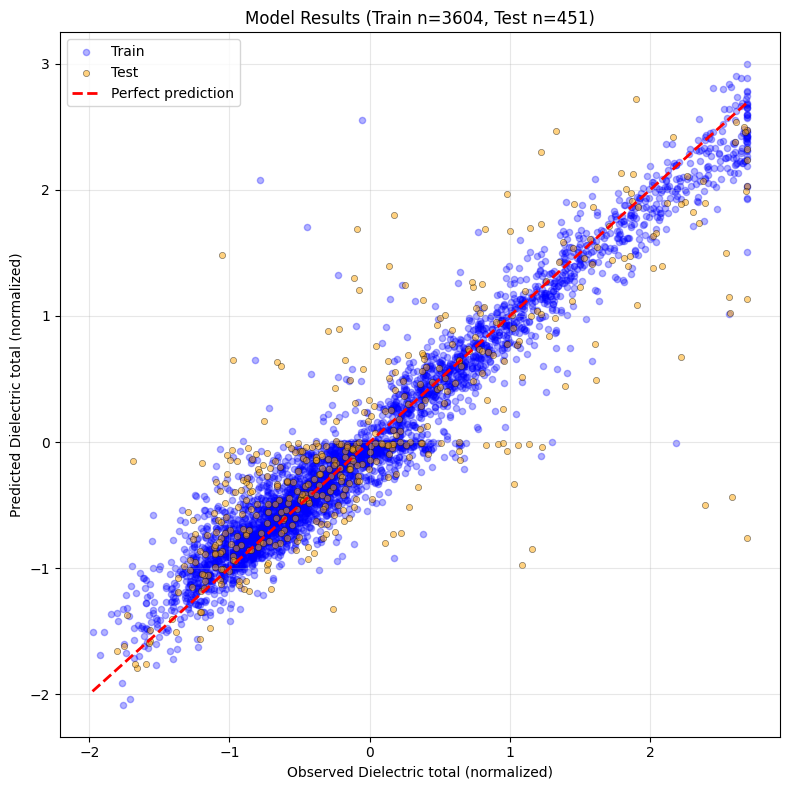


Train Set Metrics:

Test Set Metrics:

Train Set Metrics:
  MAE:  0.1731
  RMSE: 0.2502
  R²:   0.9359

Test Set Metrics:
  MAE:  0.3749
  RMSE: 0.5686
  R²:   0.6956

AutoEncoder Reconstruction Metrics (Test Set):
  MSE: 0.000971
  MAE: 0.019412


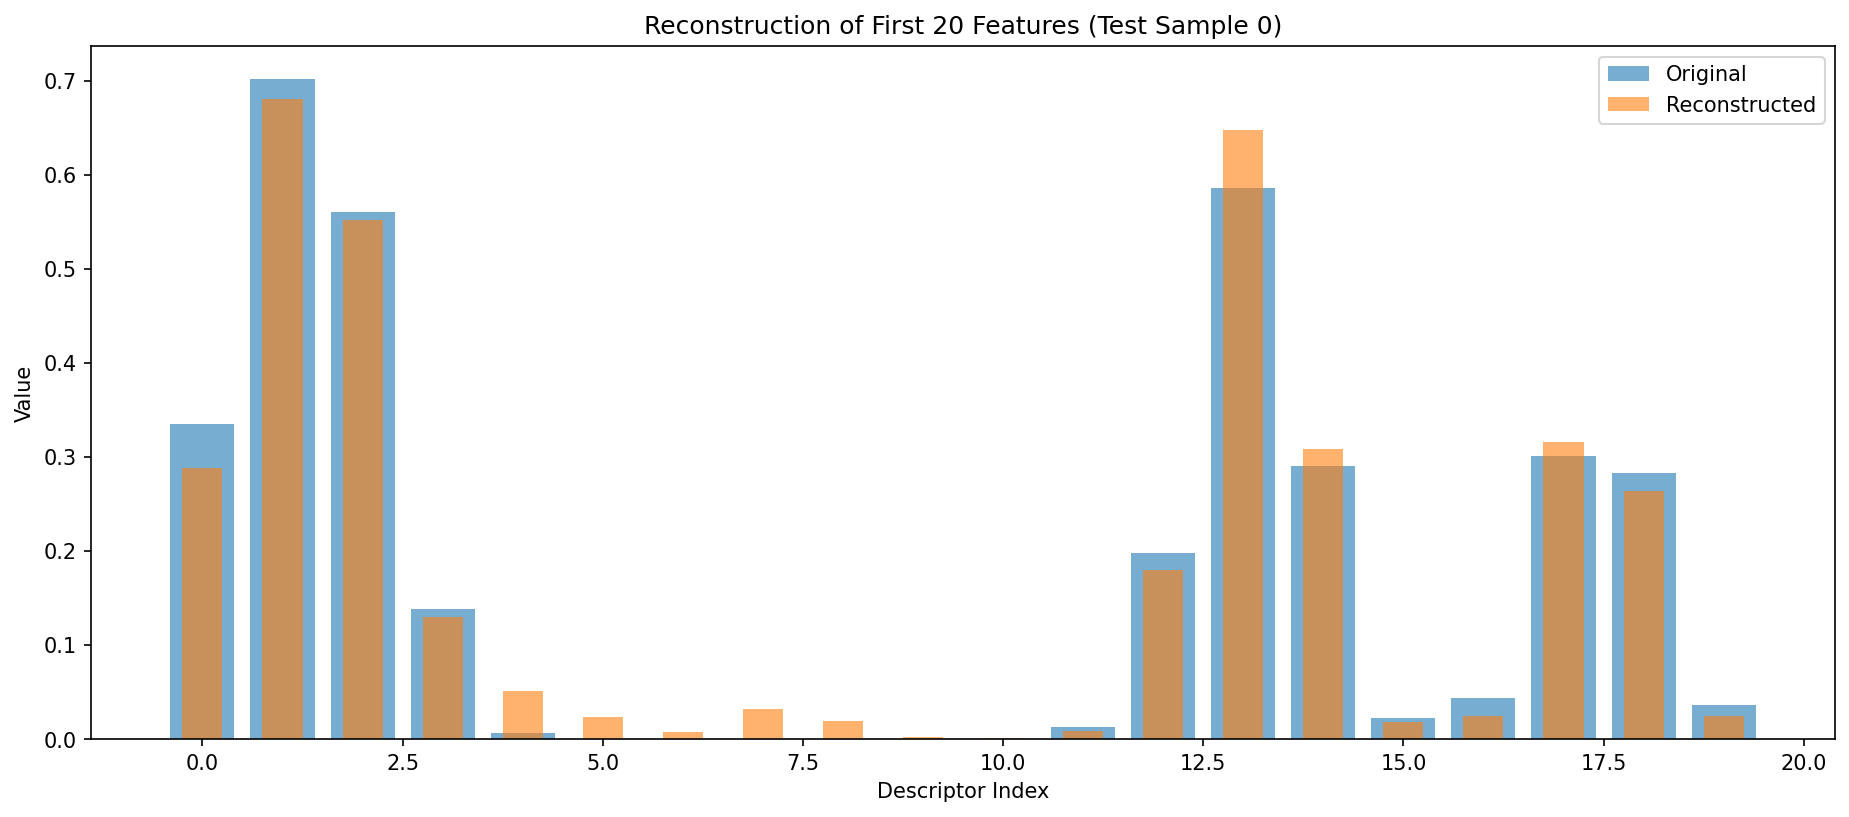


Analyzing Composition Reconstruction...

Analyzing Composition Reconstruction...


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


In [16]:
from loguru import logger as fm_logger
from matplotlib.ticker import MaxNLocator
fm_logger.disable("foundation_model")

target_name = 'Dielectric total (normalized)'
# target_name = 'Dielectric ionic (normalized)'
# target_name = 'Dielectric electronic (normalized)'

descriptor_path = Path('../data/qc_ac_te_mp_dos_kmd1d_desc_20250615.pd.parquet')
target_path = Path('../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet')

properties = pd.read_parquet(target_path)[[target_name, target_name[:-13], "composition"]]
properties.composition = properties.composition.apply(lambda x: {k: v for k, v in x.items() if v is not None})
properties = properties[properties[target_name[:-13]] < 1000]
descriptors = pd.read_parquet(descriptor_path).loc[properties.index]

# Merge and keep numeric descriptor columns
merged = descriptors.join(properties).dropna(subset=[target_name])
descriptor_cols = [c for c in descriptors.columns if pd.api.types.is_numeric_dtype(descriptors[c])]
X_full = torch.tensor(merged[descriptor_cols].values, dtype=torch.float32)
y_full = torch.tensor(merged[target_name].values, dtype=torch.float32).unsqueeze(1)

max_samples = 50000
if len(X_full) > max_samples:
    X_full = X_full[:max_samples]
    y_full = y_full[:max_samples]

# Split into train (80%), val (10%), test (10%)
n_samples = len(X_full)
indices = torch.randperm(n_samples)
n_train = int(0.8 * n_samples)
n_val = int(0.1 * n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

X = X_full[train_idx].to(device)
y = y_full[train_idx].to(device)
X_val = X_full[val_idx].to(device)
y_val = y_full[val_idx].to(device)
X_test = X_full[test_idx].to(device)
y_test = y_full[test_idx].to(device)

input_dim = X.shape[1]
latent_dim = 128

encoder_config = MLPEncoderConfig(hidden_dims=[input_dim, 256, latent_dim], norm=True)
density_task = RegressionTaskConfig(
    name=target_name,
    data_column=target_name,
    dims=[latent_dim, 64, 32, 1],
    norm=True,
)
ae_task = AutoEncoderTaskConfig(
    name='reconstruction',
    data_column='__autoencoder__',
    dims=[latent_dim, 256, input_dim],
    norm=True,
)

model = FlexibleMultiTaskModel(
    encoder_config=encoder_config,
    task_configs=[density_task, ae_task],
    shared_block_optimizer=OptimizerConfig(lr=5e-3),
).to(device)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)

model.train()
for epoch in range(500):
    total = 0.0
    for batch_x, batch_y in loader:
        optim.zero_grad()
        # UPDATED: Use model's forward() which applies Tanh uniformly
        outputs = model(batch_x)
        pred = outputs[target_name]
        recon = outputs['reconstruction']
        loss = F.mse_loss(pred, batch_y) + F.mse_loss(recon, batch_x)
        loss.backward()
        optim.step()
        total += loss.item() * batch_x.size(0)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}: loss={total / len(dataset):.4f}')

model.eval()
print(f'Training complete. Samples used: {len(dataset)}, input_dim={input_dim}')


# Scatter plot showing model predictions vs actual targets on training and test data
with torch.no_grad():
    train_preds = model(X)[target_name].cpu().numpy()
    test_preds = model(X_test)[target_name].cpu().numpy()

train_targets = y.cpu().numpy()
test_targets = y_test.cpu().numpy()
# Calculate metrics for the test set
test_mae = np.mean(np.abs(test_preds - test_targets))
test_rmse = np.sqrt(np.mean((test_preds - test_targets) ** 2))
test_r2 = 1 - np.sum((test_preds - test_targets) ** 2) / np.sum((test_targets - np.mean(test_targets)) ** 2)

# Prepare text string
metrics_text = f"Test Metrics:\nMAE: {test_mae:.4f}\nRMSE: {test_rmse:.4f}\nR²: {test_r2:.4f}"

plt.figure(figsize=(8, 8))
plt.scatter(train_targets, train_preds, alpha=0.3, s=20, label='Train', color='blue')
plt.scatter(test_targets, test_preds, alpha=0.5, s=20, label='Test', color='orange', edgecolors='k', linewidth=0.5)

all_targets = np.concatenate([train_targets, test_targets])
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel(f'Observed {target_name}')
plt.ylabel(f'Predicted {target_name}')
plt.title(f'Model Results (Train n={len(train_targets)}, Test n={len(test_targets)})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print evaluation metrics
for name, preds, targets in [('Train', train_preds, train_targets), ('Test', test_preds, test_targets)]:
    mae = np.abs(preds - targets).mean()
    rmse = np.sqrt(((preds - targets) ** 2).mean())
    r2 = 1 - ((preds - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
    print(f'\n{name} Set Metrics:')
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
show_plot()

# Print evaluation metrics
for name, preds, targets in [('Train', train_preds, train_targets), ('Test', test_preds, test_targets)]:
    mae = np.abs(preds - targets).mean()
    rmse = np.sqrt(((preds - targets) ** 2).mean())
    r2 = 1 - ((preds - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
    print(f'\n{name} Set Metrics:')
    print(f'  MAE:  {mae:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  R²:   {r2:.4f}')

# Evaluate AutoEncoder reconstruction performance
with torch.no_grad():
    # Get reconstructions for the test set
    test_outputs = model(X_test)
    test_recon = test_outputs['reconstruction']

    # Calculate reconstruction metrics (MSE and MAE)
    recon_mse = F.mse_loss(test_recon, X_test).item()
    recon_mae = torch.abs(test_recon - X_test).mean().item()

print("\nAutoEncoder Reconstruction Metrics (Test Set):")
print(f"  MSE: {recon_mse:.6f}")
print(f"  MAE: {recon_mae:.6f}")
n_features_to_plot = min(20, input_dim)
plt.figure(figsize=(15, 6), dpi=150)
plt.bar(range(n_features_to_plot), X_test[0, :n_features_to_plot].cpu().numpy(), alpha=0.6, label='Original')
plt.bar(range(n_features_to_plot), test_recon[0, :n_features_to_plot].cpu().numpy(), alpha=0.6, label='Reconstructed', width=0.5)
plt.legend()
plt.title(f'Reconstruction of First {n_features_to_plot} Features (Test Sample 0)')
plt.xlabel('Descriptor Index')
plt.ylabel('Value')
plt.show()

test_recon_np = test_recon.cpu().numpy()
joblib.dump(test_recon_np, '../data/test_reconstruct.pkl.z')

# --- NEW SECTION: Composition Reconstruction Analysis ---
print("\nAnalyzing Composition Reconstruction...")

# 1. Inverse transform descriptors to weights
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
show_plot()

test_recon_np = test_recon.cpu().numpy()
joblib.dump(test_recon_np, '../data/test_reconstruct.pkl.z')

# --- NEW SECTION: Composition Reconstruction Analysis ---
print("\nAnalyzing Composition Reconstruction...")

# 1. Inverse transform descriptors to weights
# Note: kmd_1d and component_features are expected to be in the global scope from previous cells
decoded_weights = kmd_1d.inverse_transform(test_recon_np)

# 2. Convert weights to compositions
reconstructed_compositions = decoded_weight_to_composition(
    decoded_weights,
    component_features,
    min_ratio=0.01 # Using a small threshold to filter noise
)

# 3. Get original compositions for the test set
# We need to map back from test_idx to the original properties DataFrame
test_indices_list = test_idx.cpu().numpy()
original_compositions = properties.iloc[test_indices_list]['composition'].tolist()
original_ids = properties.iloc[test_indices_list].index.tolist() # Get original IDs

# Helper function to normalize composition to percentages
def normalize_composition(comp_dict):
    total = sum(comp_dict.values())
    if total == 0: return comp_dict
    return {k: round(v / total, 3) for k, v in comp_dict.items()}

# 4. Store comparisons and visualize random samples
comparison_results = []
for i in range(len(reconstructed_compositions)):
    orig_norm = normalize_composition(original_compositions[i])
    recon = reconstructed_compositions[i]
    comparison_results.append({
        'original': orig_norm,
        'reconstructed': recon,
        'index': i,
        'id': original_ids[i] # Store original ID
    })

# Randomly select 6 samples for visualization
# random.seed(42) # For reproducibility
sample_indices = random.sample(range(len(comparison_results)), 6)

# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
fig.suptitle('Composition Reconstruction: Original vs Reconstructed (6 Random Samples)', fontsize=16)
axes = axes.flatten() # Flatten to iterate easily

for idx, sample_idx in enumerate(sample_indices):
    sample = comparison_results[sample_idx]
    orig = sample['original']
    recon = sample['reconstructed']
    sample_id = sample['id']

    # Get union of elements
    all_elements = sorted(list(set(orig.keys()) | set(recon.keys())))

    orig_vals = [orig.get(e, 0.0) for e in all_elements]
    recon_vals = [recon.get(e, 0.0) for e in all_elements]

    x = np.arange(len(all_elements))
    width = 0.35

    ax = axes[idx]
    ax.bar(x - width/2, orig_vals, width, label='Original', alpha=0.7)
    ax.bar(x + width/2, recon_vals, width, label='Reconstructed', alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(all_elements, rotation=0)
    ax.set_title(f'{sample_id}') # Use original ID in title
    if idx == 0:
        ax.set_ylabel('Composition Fraction')
        ax.legend()

show_plot()
plt.show()

# Optional: Calculate a simple similarity metric (e.g., Jaccard index of elements)
def get_elements(comp_dict):
    return set(comp_dict.keys())

## Strategy 1: Random Initialization (data-driven seed)

We start from a random seed in input space (same dimensionality as the descriptors).

In [17]:
merged[merged[target_name] > 2.6]["Dielectric total (normalized)"].max()

np.float64(2.6925720077466373)

In [18]:
# Merged Strategy: Single Seed Perturbation Analysis
import random
import joblib

# 1. Select a single random seed from the high-value candidates
# Redefine seed_batch_pd as it was in the original Cell 13
seed_batch_pd = merged[merged[target_name] > 2.6].iloc[:, :-3]

random_idx = random.randint(0, len(seed_batch_pd) - 1)
single_seed_pd = seed_batch_pd.iloc[random_idx]
single_seed_tensor = torch.tensor(single_seed_pd.values, dtype=torch.float32).to(device).unsqueeze(0)
original_id = single_seed_pd.name

print(f"Selected Seed ID: {original_id}")
print(f"Original {target_name}: {merged.loc[original_id, target_name]:.4f}")

# 2. Run optimization with perturbation (6 restarts)
num_restarts = 6
print(f"\nRunning optimization with {num_restarts} restarts (perturbation)...")

# We use the same initial input for all restarts, but the model's optimize_latent
# handles perturbation internally if num_restarts > 1 and perturbation_std > 0
result_perturb = model.optimize_latent(
    task_name=target_name,
    initial_input=single_seed_tensor,
    # mode="max",
    target_value=3.0,
    steps=300,
    lr=0.005,
    num_restarts=num_restarts,
    perturbation_std=0.3,
    optimize_space="latent",
    ae_task_name="reconstruction",
)

# 3. Visualize Optimization Process
traj = result_perturb.trajectory[0, :, :, 0].detach().cpu().numpy() # (num_restarts, steps)
plt.figure(figsize=(10, 5), dpi=150)
for i in range(num_restarts):
    final_score = result_perturb.optimized_target[0, i, 0].item()
    plt.plot(traj[i], label=f'Restart {i} ({final_score:.2f})')
plt.xlabel('Optimization Step')
plt.ylabel(f'{target_name} Score')
plt.title(f'Optimization Trajectories for ID: {original_id}')
plt.legend()
plt.grid(alpha=0.3)
show_plot()

# 4. Analyze Composition Reconstruction
print("\nAnalyzing Composition Reconstruction for each restart...")

# Get optimized inputs (reconstructed descriptors)
optimized_inputs = result_perturb.optimized_input[0].detach().cpu().numpy() # (num_restarts, input_dim)

# Inverse transform to compositions
decoded_weights = kmd_1d.inverse_transform(optimized_inputs)
reconstructed_compositions = decoded_weight_to_composition(
    decoded_weights,
    component_features,
    min_ratio=0.01
)

# Get original composition
original_comp_dict = properties.loc[original_id, 'composition']
original_comp_norm = normalize_composition(original_comp_dict)

# Plot 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
fig.suptitle(f'Composition Reconstruction per Restart (ID: {original_id})', fontsize=16)
axes = axes.flatten()

for i in range(num_restarts):
    recon = reconstructed_compositions[i]

    # Union of elements
    all_elements = sorted(list(set(original_comp_norm.keys()) | set(recon.keys())))

    orig_vals = [original_comp_norm.get(e, 0.0) for e in all_elements]
    recon_vals = [recon.get(e, 0.0) for e in all_elements]

    x = np.arange(len(all_elements))
    width = 0.35

    ax = axes[i]
    ax.bar(x - width/2, orig_vals, width, label='Original', alpha=0.7)
    ax.bar(x + width/2, recon_vals, width, label='Reconstructed', alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(all_elements, rotation=0)
    ax.set_title(f'Restart {i}')
    if i == 0:
        ax.set_ylabel('Composition Fraction')
        ax.legend()

plt.tight_layout()
show_plot()

# 5. Compare Predictions: Optimized Score vs Actual Prediction on Reconstructed
print("\nPrediction Consistency Check:")

# Get original values and initial prediction
original_val_norm = merged.loc[original_id, target_name]
original_val_raw = merged.loc[original_id, target_name[:-13]]

with torch.no_grad():
    initial_pred = model(single_seed_tensor)[target_name].item()

print(f"Original ID: {original_id}")
print(f"Original Value (Raw):  {original_val_raw:.4f}")

print("-" * 100)
print(f"{'Restart':<8} | {'Orig(Norm)':<12} | {'Init Pred':<12} | {'Target Score':<12} | {'Recon Pred':<12} | {'Consist Diff':<12}")
print("-" * 100)

# Predict using the model on the reconstructed inputs
with torch.no_grad():
    # optimized_inputs is numpy, convert to tensor
    inputs_tensor = torch.tensor(optimized_inputs, dtype=torch.float32).to(device)
    predictions = model(inputs_tensor)[target_name].cpu().numpy().flatten()

optimized_scores = result_perturb.optimized_target[0, :, 0].detach().cpu().numpy()

consistency_data = []
for i in range(num_restarts):
    target_score = optimized_scores[i]
    pred_score = predictions[i]

    # Consistency Diff: Difference between model prediction on reconstructed input and the optimization target
    # (Recon Pred - Target Score)
    consist_diff = pred_score - target_score

    print(f"{i:<8} | {original_val_norm:<12.4f} | {initial_pred:<12.4f} | {target_score:<12.4f} | {pred_score:<12.4f} | {consist_diff:<12.4f}")

    consistency_data.append({
        'Restart': i,
        'Original ID': original_id,
        'Original Value (Raw)': original_val_raw,
        'Original Value (Norm)': original_val_norm,
        'Initial Prediction': initial_pred,
        'Target Score': target_score,
        'Recon Prediction': pred_score,
        'Consistency Diff': consist_diff
    })

# Save consistency results
consistency_df = pd.DataFrame(consistency_data)
consistency_df.to_csv('../data/prediction_consistency.csv', index=False)
print("\nPrediction consistency results saved to '../data/prediction_consistency.csv'")
print("Definitions:")
print("  Target Score:     The score achieved by the latent optimization process.")
print("  Recon Prediction: The model's prediction on the reconstructed descriptors.")
print("  Consistency Diff: (Recon Prediction - Target Score). Measures if the reconstructed input preserves the optimized property.")

# 6. Analyze Reconstructed Descriptors
print("\nAnalyzing Reconstructed Descriptors...")

descriptors_ = {
    'Original': single_seed_pd.values.flatten(),
    'Multi-Restart (mean)': optimized_inputs.mean(axis=0),
}

# Visualize first n_show features with error bars
n_show = 150
fig, axes = plt.subplots(3, 1, figsize=(16, 7), sharex=True, dpi=150)

# Original plot
axes[0].bar(range(n_show), descriptors_['Original'][:n_show], alpha=0.7)
axes[0].set_ylabel('Descriptor value')
axes[0].set_title(f'Original descriptor (ID: {original_id})')
axes[0].grid(alpha=0.3, axis='y')

# Multi-restart mean with std as error bars
mean_vals = optimized_inputs.mean(axis=0)[:n_show]
std_vals = optimized_inputs.std(axis=0)[:n_show]
axes[1].bar(range(n_show), mean_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6})
axes[1].set_ylabel('Descriptor value')
axes[1].set_title(f'Reconstructed (mean ± std over {num_restarts} restarts)')
axes[1].grid(alpha=0.3, axis='y')

# Difference: Multi-Restart (mean) - Original with error bars
diff_vals = mean_vals - descriptors_['Original'][:n_show]
axes[2].bar(range(n_show), diff_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6}, color='green')
axes[2].axhline(0, color='gray', linestyle='-', linewidth=1)
axes[2].set_xlabel('Descriptor index')
axes[2].set_ylabel('Difference')
axes[2].set_title('Reconstructed (mean) - Original (± std)')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
show_plot()

# Statistical comparison
print('Descriptor statistics (first 100 features):')
for name, desc in descriptors_.items():
    print(f"{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")

# Save results
joblib.dump(result_perturb, '../data/advanced_optimization_result.pkl.z')

Selected Seed ID: mp-675989
Original Dielectric total (normalized): 2.6799

Running optimization with 6 restarts (perturbation)...

Analyzing Composition Reconstruction for each restart...

Prediction Consistency Check:
Original ID: mp-675989
Original Value (Raw):  141.5385
----------------------------------------------------------------------------------------------------
Restart  | Orig(Norm)   | Init Pred    | Target Score | Recon Pred   | Consist Diff
----------------------------------------------------------------------------------------------------
0        | 2.6799       | 2.2310       | 3.0000       | 1.9164       | -1.0836     
1        | 2.6799       | 2.2310       | 3.0000       | 2.1524       | -0.8476     
2        | 2.6799       | 2.2310       | 3.0000       | 1.8846       | -1.1154     
3        | 2.6799       | 2.2310       | 3.0000       | 1.9041       | -1.0959     
4        | 2.6799       | 2.2310       | 3.0000       | 2.2135       | -0.7865     
5        | 2.6799  

/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


Descriptor statistics (first 100 features):
Original:
  Mean: 0.1753
  Std: 0.2422
  Range: [0.0000, 0.9235]
Multi-Restart (mean):
  Mean: 0.1736
  Std: 0.2290
  Range: [0.0017, 0.8588]


['../data/advanced_optimization_result.pkl.z']

In [19]:
# Sensitivity Analysis: Target Score vs Recon Prediction (Batch of 10)
# Randomly select 10 samples with Target > 1.5 and run sensitivity analysis on each.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import os

# Create directory for results
output_dir = '../data/sensitivity_analysis_results_20260204'
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

# 1. Select 10 random IDs with target > 1.5
candidates = merged[merged[target_name] > 1.5]
if len(candidates) < 10:
    print(f"Warning: Only {len(candidates)} candidates found with {target_name} > 1.5. Using all.")
    selected_ids = candidates.index.tolist()
else:
    selected_ids = random.sample(candidates.index.tolist(), 100)

print(f"Selected 10 IDs for analysis: {selected_ids}")

# Ensure normalize_composition is available
def normalize_composition(comp_dict):
    total = sum(comp_dict.values())
    if total == 0: return comp_dict
    return {k: round(v / total, 3) for k, v in comp_dict.items()}

for idx, original_id in enumerate(selected_ids):
    print(f"\n{'='*50}")
    print(f"Processing ID {idx+1}/10: {original_id}")
    print(f"{'='*50}")

    # Prepare input tensor
    # Use descriptor_cols to extract only the features
    # Explicitly cast to float32 to avoid object dtype issues
    single_seed_values = merged.loc[original_id, descriptor_cols].values.astype(np.float32)
    single_seed_tensor = torch.tensor(single_seed_values, dtype=torch.float32).to(device).unsqueeze(0)

    # Get original values
    start_val = merged.loc[original_id, target_name]
    orig_comp = properties.loc[original_id, 'composition']
    orig_comp_norm = normalize_composition(orig_comp)

    # Get Initial Prediction
    with torch.no_grad():
        initial_pred = model(single_seed_tensor)[target_name].item()

    # Define target range
    # Start from the ceiling of the current value to the nearest 0.1
    start_target = np.ceil(start_val * 10) / 10
    # Generate 10 steps of 0.1 increase
    target_values = [start_target + i * 0.1 for i in range(11)]

    print(f"Original Value: {start_val:.4f}")
    print(f"Initial Pred:   {initial_pred:.4f}")
    # Simplified f-string to avoid potential syntax errors in some environments
    formatted_targets = [f'{t:.2f}' for t in target_values]
    print(f"Target Values: {formatted_targets}")

    results_sensitivity = []
    all_results_detailed = []

    for target in target_values:
        print(f"  Optimizing for target: {target:.2f}...", end='\r')

        # Run optimization with 50 restarts
        res = model.optimize_latent(
            task_name=target_name,
            initial_input=single_seed_tensor,
            mode="max",
            target_value=target,
            steps=300,   # Reduced steps for speed
            lr=0.005,     # Increased LR for speed
            num_restarts=20,
            perturbation_std=0.3,
            optimize_space="latent",
            ae_task_name="reconstruction",
        )

        # Get reconstructed predictions
        optimized_inputs = res.optimized_input[0].detach().cpu().numpy()
        inputs_tensor = torch.tensor(optimized_inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            preds = model(inputs_tensor)[target_name].cpu().numpy().flatten()

        # Decode Compositions
        decoded_weights = kmd_1d.inverse_transform(optimized_inputs)
        recon_comps = decoded_weight_to_composition(decoded_weights, component_features, min_ratio=0.05)

        # Store Detailed Results
        achieved_scores = res.optimized_target[0, :, 0].detach().cpu().numpy()

        for i in range(len(preds)):
            all_results_detailed.append({
                'Target Score': target,
                'Restart': i,
                'Original ID': original_id,
                'Original True Value': start_val,
                'Original Initial Prediction': initial_pred,
                'Original Composition': str(orig_comp),
                'Original Composition (Norm)': str(orig_comp_norm),
                'Reconstructed Composition': str(recon_comps[i]),
                'Reconstructed Prediction': preds[i],
                'Achieved Optimization Score': achieved_scores[i]
            })

        # Calculate stats
        mean_pred = np.mean(preds)
        std_pred = np.std(preds)
        stderr_pred = std_pred / np.sqrt(len(preds))

        results_sensitivity.append({
            'Target Score': target,
            'Recon Pred Mean': mean_pred,
            'Recon Pred Std': std_pred,
            'Recon Pred StdErr': stderr_pred
        })

    print(f"\n  Optimization complete for {original_id}.")

    # Save Results to output_dir (Modified Filenames)
    detailed_df = pd.DataFrame(all_results_detailed)
    detailed_df.to_csv(os.path.join(output_dir, f'{original_id}_sensitivity_detailed.csv'), index=False)

    sensitivity_df = pd.DataFrame(results_sensitivity)
    sensitivity_df.to_csv(os.path.join(output_dir, f'{original_id}_sensitivity_summary.csv'), index=False)

    # Plotting
    plt.figure(figsize=(10, 6), dpi=150)

    plt.plot(sensitivity_df['Target Score'], sensitivity_df['Recon Pred Mean'],
             marker='o', label='Mean Recon Pred', color='blue')

    plt.fill_between(
        sensitivity_df['Target Score'],
        sensitivity_df['Recon Pred Mean'] - sensitivity_df['Recon Pred StdErr'],
        sensitivity_df['Recon Pred Mean'] + sensitivity_df['Recon Pred StdErr'],
        color='blue', alpha=0.2, label='Std Error'
    )

    plt.xlabel('Target Score')
    plt.ylabel('Reconstructed Prediction')

    # Updated Title with Original Value and Initial Prediction
    title_str = f'Sensitivity Analysis: Target Score vs Recon Prediction\nID: {original_id}\n(True: {start_val:.4f}, Pred: {initial_pred:.4f})'
    plt.title(title_str)

    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(output_dir, f'{original_id}_sensitivity.png'))
    show_plot()

print(f"\nAll 10 samples processed. Results saved to '{output_dir}'.")

Results will be saved to: ../data/sensitivity_analysis_results_20260204
Selected 10 IDs for analysis: ['mp-11265', 'mp-867899', 'mp-556094', 'mp-568540', 'mp-22791', 'mp-1216623', 'mp-1214505', 'mp-556489', 'mp-3839', 'mp-21276', 'mp-31149', 'mp-23202', 'mp-22859', 'mp-28373', 'mp-1214475', 'mp-8281', 'mp-29711', 'mp-2160', 'mp-571189', 'mp-1208643', 'mp-34202', 'mp-625394', 'mp-1220879', 'mp-1106', 'mp-1317', 'mp-30301', 'mp-774797', 'mp-23084', 'mp-2455', 'mp-9899', 'mp-1101917', 'mp-554669', 'mp-861937', 'mp-1025039', 'mp-753798', 'mp-861507', 'mp-1212441', 'mp-27655', 'mp-1080848', 'mp-1029625', 'mp-1219458', 'mp-504554', 'mp-1014251', 'mp-10667', 'mp-766', 'mp-1218926', 'mp-614013', 'mp-23262', 'mp-998552', 'mp-28080', 'mp-570008', 'mp-14873', 'mp-1247', 'mp-2576', 'mp-7691', 'mp-3858', 'mp-865892', 'mp-1103722', 'mp-978852', 'mp-2809', 'mp-1101894', 'mp-568848', 'mp-554921', 'mp-13660', 'mp-18815', 'mp-10401', 'mp-22964', 'mp-768223', 'mp-638061', 'mp-5625', 'mp-559151', 'mp-1205

/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-11265.

Processing ID 2/10: mp-867899
Original Value: 2.1858
Initial Pred:   1.9287
Target Values: ['2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.20...
  Optimization complete for mp-867899.

Processing ID 3/10: mp-556094
Original Value: 2.6548
Initial Pred:   2.6891
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-556094.

Processing ID 4/10: mp-568540
Original Value: 2.6088
Initial Pred:   2.6248
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-568540.

Processing ID 5/10: mp-22791
Original Value: 2.1812
Initial Pred:   2.0891
Target Values: ['2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.20...
  Optimization complete for mp-22791.

Processing ID 6/10: mp-1216623
Original Value: 1.5107
Initial Pred:   1.8786
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-1216623.

Processing ID 7/10: mp-1214505
Original Value: 1.8943
Initial Pred:   1.8524
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-1214505.

Processing ID 8/10: mp-556489
Original Value: 2.3576
Initial Pred:   2.0661
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-556489.

Processing ID 9/10: mp-3839
Original Value: 1.8729
Initial Pred:   1.3825
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-3839.

Processing ID 10/10: mp-21276
Original Value: 2.6926
Initial Pred:   2.4589
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-21276.

Processing ID 11/10: mp-31149
Original Value: 1.6099
Initial Pred:   2.0870
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-31149.

Processing ID 12/10: mp-23202
Original Value: 1.9642
Initial Pred:   1.6411
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-23202.

Processing ID 13/10: mp-22859
Original Value: 1.8669
Initial Pred:   1.3354
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-22859.

Processing ID 14/10: mp-28373
Original Value: 1.6038
Initial Pred:   0.7783
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-28373.

Processing ID 15/10: mp-1214475
Original Value: 1.9189
Initial Pred:   1.9176
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-1214475.

Processing ID 16/10: mp-8281
Original Value: 2.6491
Initial Pred:   1.9108
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-8281.

Processing ID 17/10: mp-29711
Original Value: 2.4923
Initial Pred:   2.2850
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-29711.

Processing ID 18/10: mp-2160
Original Value: 2.3874
Initial Pred:   2.3307
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-2160.

Processing ID 19/10: mp-571189
Original Value: 1.6964
Initial Pred:   1.5130
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-571189.

Processing ID 20/10: mp-1208643
Original Value: 2.0168
Initial Pred:   1.8587
Target Values: ['2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.10...
  Optimization complete for mp-1208643.

Processing ID 21/10: mp-34202
Original Value: 2.5916
Initial Pred:   2.2518
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-34202.

Processing ID 22/10: mp-625394
Original Value: 2.6917
Initial Pred:   2.4743
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-625394.

Processing ID 23/10: mp-1220879
Original Value: 2.5009
Initial Pred:   2.1711
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-1220879.

Processing ID 24/10: mp-1106
Original Value: 1.5042
Initial Pred:   1.4889
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-1106.

Processing ID 25/10: mp-1317
Original Value: 2.0440
Initial Pred:   1.3614
Target Values: ['2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.10...
  Optimization complete for mp-1317.

Processing ID 26/10: mp-30301
Original Value: 2.1857
Initial Pred:   -0.0114
Target Values: ['2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.20...
  Optimization complete for mp-30301.

Processing ID 27/10: mp-774797
Original Value: 1.8921
Initial Pred:   1.5196
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-774797.

Processing ID 28/10: mp-23084
Original Value: 1.5007
Initial Pred:   1.5703
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-23084.

Processing ID 29/10: mp-2455
Original Value: 1.6237
Initial Pred:   1.6618
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-2455.

Processing ID 30/10: mp-9899
Original Value: 1.9514
Initial Pred:   1.8596
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-9899.

Processing ID 31/10: mp-1101917
Original Value: 2.6085
Initial Pred:   2.3760
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1101917.

Processing ID 32/10: mp-554669
Original Value: 2.3376
Initial Pred:   1.9115
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-554669.

Processing ID 33/10: mp-861937
Original Value: 1.7842
Initial Pred:   1.2682
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-861937.

Processing ID 34/10: mp-1025039
Original Value: 2.5671
Initial Pred:   2.6157
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-1025039.

Processing ID 35/10: mp-753798
Original Value: 2.3890
Initial Pred:   -0.5003
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-753798.

Processing ID 36/10: mp-861507
Original Value: 1.8642
Initial Pred:   1.8031
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-861507.

Processing ID 37/10: mp-1212441
Original Value: 2.0867
Initial Pred:   1.3930
Target Values: ['2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.10...
  Optimization complete for mp-1212441.

Processing ID 38/10: mp-27655
Original Value: 1.6213
Initial Pred:   1.2011
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-27655.

Processing ID 39/10: mp-1080848
Original Value: 1.8586
Initial Pred:   1.7780
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-1080848.

Processing ID 40/10: mp-1029625
Original Value: 2.6898
Initial Pred:   2.3750
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1029625.

Processing ID 41/10: mp-1219458
Original Value: 1.6569
Initial Pred:   1.3967
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-1219458.

Processing ID 42/10: mp-504554
Original Value: 2.0781
Initial Pred:   1.9856
Target Values: ['2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.10...
  Optimization complete for mp-504554.

Processing ID 43/10: mp-1014251
Original Value: 1.6682
Initial Pred:   1.6204
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-1014251.

Processing ID 44/10: mp-10667
Original Value: 2.6805
Initial Pred:   2.7201
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-10667.

Processing ID 45/10: mp-766
Original Value: 1.7638
Initial Pred:   1.6156
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-766.

Processing ID 46/10: mp-1218926
Original Value: 1.6588
Initial Pred:   1.5101
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-1218926.

Processing ID 47/10: mp-614013
Original Value: 2.6883
Initial Pred:   2.2453
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-614013.

Processing ID 48/10: mp-23262
Original Value: 1.5937
Initial Pred:   1.8659
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-23262.

Processing ID 49/10: mp-998552
Original Value: 1.8757
Initial Pred:   1.7862
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-998552.

Processing ID 50/10: mp-28080
Original Value: 1.8111
Initial Pred:   1.4623
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-28080.

Processing ID 51/10: mp-570008
Original Value: 2.0605
Initial Pred:   2.0048
Target Values: ['2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.10...
  Optimization complete for mp-570008.

Processing ID 52/10: mp-14873
Original Value: 2.4801
Initial Pred:   1.8476
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-14873.

Processing ID 53/10: mp-1247
Original Value: 1.6261
Initial Pred:   1.4295
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-1247.

Processing ID 54/10: mp-2576
Original Value: 1.5838
Initial Pred:   1.4281
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-2576.

Processing ID 55/10: mp-7691
Original Value: 1.8882
Initial Pred:   1.7316
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-7691.

Processing ID 56/10: mp-3858
Original Value: 2.6926
Initial Pred:   2.5948
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-3858.

Processing ID 57/10: mp-865892
Original Value: 1.5961
Initial Pred:   1.5658
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-865892.

Processing ID 58/10: mp-1103722
Original Value: 1.9461
Initial Pred:   2.0117
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-1103722.

Processing ID 59/10: mp-978852
Original Value: 1.8131
Initial Pred:   1.7556
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-978852.

Processing ID 60/10: mp-2809
Original Value: 2.2780
Initial Pred:   2.0979
Target Values: ['2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.30...
  Optimization complete for mp-2809.

Processing ID 61/10: mp-1101894
Original Value: 1.8973
Initial Pred:   1.7732
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-1101894.

Processing ID 62/10: mp-568848
Original Value: 2.6917
Initial Pred:   -0.7609
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-568848.

Processing ID 63/10: mp-554921
Original Value: 2.6926
Initial Pred:   2.3195
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-554921.

Processing ID 64/10: mp-13660
Original Value: 1.6479
Initial Pred:   1.6852
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-13660.

Processing ID 65/10: mp-18815
Original Value: 1.5826
Initial Pred:   0.6456
Target Values: ['1.60', '1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.60...
  Optimization complete for mp-18815.

Processing ID 66/10: mp-10401
Original Value: 1.9123
Initial Pred:   1.8713
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-10401.

Processing ID 67/10: mp-22964
Original Value: 2.4336
Initial Pred:   2.4051
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-22964.

Processing ID 68/10: mp-768223
Original Value: 2.3980
Initial Pred:   2.2879
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-768223.

Processing ID 69/10: mp-638061
Original Value: 2.1141
Initial Pred:   2.3646
Target Values: ['2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.20...
  Optimization complete for mp-638061.

Processing ID 70/10: mp-5625
Original Value: 1.6324
Initial Pred:   1.1215
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-5625.

Processing ID 71/10: mp-559151
Original Value: 2.2472
Initial Pred:   1.9038
Target Values: ['2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.30...
  Optimization complete for mp-559151.

Processing ID 72/10: mp-1205391
Original Value: 2.2025
Initial Pred:   2.0902
Target Values: ['2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.30...
  Optimization complete for mp-1205391.

Processing ID 73/10: mp-7771
Original Value: 2.6832
Initial Pred:   2.4127
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-7771.

Processing ID 74/10: mp-755190
Original Value: 1.9202
Initial Pred:   1.6916
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-755190.

Processing ID 75/10: mp-3525
Original Value: 2.5436
Initial Pred:   2.2544
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-3525.

Processing ID 76/10: mp-1029293
Original Value: 2.4994
Initial Pred:   2.2314
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-1029293.

Processing ID 77/10: mp-3652
Original Value: 2.4377
Initial Pred:   0.9220
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-3652.

Processing ID 78/10: mp-1228446
Original Value: 2.5991
Initial Pred:   2.1370
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-1228446.

Processing ID 79/10: mp-1029267
Original Value: 2.6447
Initial Pred:   2.8851
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1029267.

Processing ID 80/10: mp-1209072
Original Value: 2.4308
Initial Pred:   2.2678
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-1209072.

Processing ID 81/10: mp-998778
Original Value: 2.5818
Initial Pred:   -0.4384
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-998778.

Processing ID 82/10: mp-865278
Original Value: 2.2606
Initial Pred:   2.0863
Target Values: ['2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.30...
  Optimization complete for mp-865278.

Processing ID 83/10: mp-1321
Original Value: 1.7994
Initial Pred:   2.4612
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-1321.

Processing ID 84/10: mp-862947
Original Value: 1.7387
Initial Pred:   1.5361
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-862947.

Processing ID 85/10: mp-30303
Original Value: 1.8042
Initial Pred:   1.7533
Target Values: ['1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.90...
  Optimization complete for mp-30303.

Processing ID 86/10: mp-2488
Original Value: 1.7187
Initial Pred:   1.7792
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-2488.

Processing ID 87/10: mp-27832
Original Value: 2.6281
Initial Pred:   0.0070
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-27832.

Processing ID 88/10: mp-866105
Original Value: 2.6921
Initial Pred:   2.7794
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-866105.

Processing ID 89/10: mp-7148
Original Value: 2.2536
Initial Pred:   1.9862
Target Values: ['2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.30...
  Optimization complete for mp-7148.

Processing ID 90/10: mp-1213697
Original Value: 2.4978
Initial Pred:   2.3752
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-1213697.

Processing ID 91/10: mp-1079050
Original Value: 2.6455
Initial Pred:   2.3055
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1079050.

Processing ID 92/10: mp-390
Original Value: 2.3834
Initial Pred:   1.7489
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-390.

Processing ID 93/10: mp-2008
Original Value: 2.1216
Initial Pred:   1.8957
Target Values: ['2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.20...
  Optimization complete for mp-2008.

Processing ID 94/10: mp-1095603
Original Value: 2.6926
Initial Pred:   2.5974
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1095603.

Processing ID 95/10: mp-27849
Original Value: 2.1242
Initial Pred:   2.1205
Target Values: ['2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.20...
  Optimization complete for mp-27849.

Processing ID 96/10: mp-4185
Original Value: 2.5200
Initial Pred:   2.7976
Target Values: ['2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.60...
  Optimization complete for mp-4185.

Processing ID 97/10: mp-13055
Original Value: 1.9883
Initial Pred:   2.0093
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-13055.

Processing ID 98/10: mp-1201
Original Value: 2.6706
Initial Pred:   2.4790
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1201.

Processing ID 99/10: mp-1029826
Original Value: 2.6924
Initial Pred:   1.5044
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-1029826.

Processing ID 100/10: mp-16610
Original Value: 2.4149
Initial Pred:   2.3109
Target Values: ['2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.50...
  Optimization complete for mp-16610.

All 10 samples processed. Results saved to '../data/sensitivity_analysis_results_20260204'.


In [20]:

# Aggregate best restart per (Original ID, Target Score) across all sensitivity_detailed.csv files
import glob

sensitivity_dir = '../data/sensitivity_analysis_results_20260204'
detailed_files = sorted(glob.glob(os.path.join(sensitivity_dir, '*_sensitivity_detailed.csv')))

print(f"Found {len(detailed_files)} detailed CSV files in: {sensitivity_dir}")

all_best_rows = []
for fpath in detailed_files:
    df = pd.read_csv(fpath)
    # For each (Original ID, Target Score), keep the row with the highest Reconstructed Prediction
    best_idx = df.groupby(['Original ID', 'Target Score'])['Reconstructed Prediction'].idxmax()
    best_rows = df.loc[best_idx]
    all_best_rows.append(best_rows)
    print(f"  {os.path.basename(fpath)}: {len(best_rows)} best rows from {len(df)} total")

best_df = pd.concat(all_best_rows, ignore_index=True)
print(f"\nAggregated DataFrame: {best_df.shape[0]} rows x {best_df.shape[1]} columns")

# Save
output_path = os.path.join(sensitivity_dir, 'best_restart_per_target.csv')
best_df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")
best_df


Found 100 detailed CSV files in: ../data/sensitivity_analysis_results_20260204
  mp-1014251_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1025039_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1029267_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1029293_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1029625_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1029826_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-10401_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-10667_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1079050_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1080848_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1095603_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1101894_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1101917_sensitivity_detailed.csv: 11 best rows from 220 total
  mp-1103722_sensitivity_detailed.csv: 11 best rows fr

,Target Score,Restart,Original ID,Original True Value,Original Initial Prediction,Original Composition,Original Composition (Norm),Reconstructed Composition,Reconstructed Prediction,Achieved Optimization Score
0,1.7,9,mp-1014251,1.668193,1.620449,"{'Hf': 1.0, 'N': 2.0, 'Zn': 1.0}","{'Hf': 0.25, 'N': 0.5, 'Zn': 0.25}","{'N': 0.485, 'Mg': 0.1, 'Zr': 0.1, 'Cd': 0.11,...",1.979931,1.700000
1,1.8,19,mp-1014251,1.668193,1.620449,"{'Hf': 1.0, 'N': 2.0, 'Zn': 1.0}","{'Hf': 0.25, 'N': 0.5, 'Zn': 0.25}","{'N': 0.485, 'Zn': 0.12, 'Zr': 0.125, 'Hf': 0....",2.117186,1.800000
2,1.9,15,mp-1014251,1.668193,1.620449,"{'Hf': 1.0, 'N': 2.0, 'Zn': 1.0}","{'Hf': 0.25, 'N': 0.5, 'Zn': 0.25}","{'N': 0.58, 'Zn': 0.155, 'Hf': 0.265}",2.144278,1.900000
3,2.0,19,mp-1014251,1.668193,1.620449,"{'Hf': 1.0, 'N': 2.0, 'Zn': 1.0}","{'Hf': 0.25, 'N': 0.5, 'Zn': 0.25}","{'N': 0.625, 'V': 0.135, 'Hf': 0.245}",2.043573,2.000000
4,2.1,1,mp-1014251,1.668193,1.620449,"{'Hf': 1.0, 'N': 2.0, 'Zn': 1.0}","{'Hf': 0.25, 'N': 0.5, 'Zn': 0.25}","{'N': 0.55, 'Zn': 0.18, 'Hf': 0.27}",2.246046,2.100000
...,...,...,...,...,...,...,...,...,...,...
1095,3.2,13,mp-998778,2.581812,-0.438404,"{'Br': 12.0, 'Rb': 4.0, 'Sn': 4.0}","{'Br': 0.6, 'Rb': 0.2, 'Sn': 0.2}","{'Cl': 0.085, 'Br': 0.49, 'Rb': 0.165, 'Sn': 0...",-0.235902,3.200003
1096,3.3,4,mp-998778,2.581812,-0.438404,"{'Br': 12.0, 'Rb': 4.0, 'Sn': 4.0}","{'Br': 0.6, 'Rb': 0.2, 'Sn': 0.2}","{'Br': 0.48, 'Rb': 0.265, 'In': 0.12, 'I': 0.135}",-0.252045,3.299999
1097,3.4,5,mp-998778,2.581812,-0.438404,"{'Br': 12.0, 'Rb': 4.0, 'Sn': 4.0}","{'Br': 0.6, 'Rb': 0.2, 'Sn': 0.2}","{'Cl': 0.11, 'Br': 0.445, 'Rb': 0.18, 'Sn': 0....",-0.124845,3.400000
1098,3.5,18,mp-998778,2.581812,-0.438404,"{'Br': 12.0, 'Rb': 4.0, 'Sn': 4.0}","{'Br': 0.6, 'Rb': 0.2, 'Sn': 0.2}","{'O': 0.105, 'Cl': 0.095, 'Se': 0.105, 'Br': 0...",-0.198260,3.500001
